# Classify different data sets

### Basic includes

In [1]:
# Using pandas to load the csv file
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from keras import models 
from keras import layers 
from keras import callbacks
from keras.utils import to_categorical
from keras import backend as K
from keras import optimizers

# reuters and fashin mnist data set from keras
from keras.datasets import reuters
from keras.datasets import fashion_mnist

# needed to preprocess text
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


### Classify the Fashion Mnist

---

(60000, 28, 28)
(60000,)
0


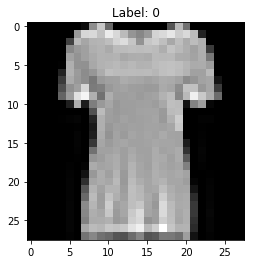

In [2]:
(fashion_train_data, fashion_train_labels), (fashion_test_data, fashion_test_labels) = fashion_mnist.load_data()

print(fashion_train_data.shape)
print(fashion_train_labels.shape)
print(fashion_train_labels[10])

test_index = 10

plt.title("Label: " + str(fashion_train_labels[test_index]))
plt.imshow(fashion_train_data[test_index], cmap="gray")

#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [3]:
# Standardize the data

# flatten arrays
fashion_train_data = fashion_train_data.reshape((60000, 28 * 28))

# turn values from 0-255 to 0-1
fashion_train_data = fashion_train_data.astype('float32') / 255 

# same starndadization for the test images
fashion_test_data = fashion_test_data.reshape((10000, 28 * 28)) 
fashion_test_data = fashion_test_data.astype('float32') / 255


# One hot encoding
fashion_train_encoded = to_categorical(fashion_train_labels)
fashion_test_encoded = to_categorical(fashion_test_labels)

print(fashion_train_data.shape)


# Building the model architecture
model = models.Sequential()
model.add(layers.Dense(784, activation='relu', input_dim=784))
# Added dropout between the input and first hidden layer
model.add(layers.Dropout(0.2))
model.add(layers.Dense(375, activation='relu', input_dim=784))
# Added dropout between the input and first hidden layer
model.add(layers.Dropout(0.2))
model.add(layers.Dense(49, activation='relu'))
# Added dropout between the first hidden layer and the second one
model.add(layers.Dropout(0.2))
model.add(layers.Dense(25, activation='relu'))
# Added dropout between the first hidden layer and the second one
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

# included the early stopping which monitors the validation loss
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='categorical_crossentropy', 
              optimizer='adamax',
              metrics=['categorical_accuracy'])

history = model.fit(fashion_train_data, fashion_train_encoded,
          batch_size=1024,
          epochs=100,
          validation_split=0.2,
          callbacks=[early_stop], 
          verbose=2)

(60000, 784)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 375)               294375    
_________________________________________________________________
dropout_2 (Dropout)          (None, 375)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 49)                18424     
_________________________________________________________________
dropout_3 (Dropout)          (None, 49)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1250    

In [4]:
results = model.evaluate(fashion_test_data, fashion_test_encoded)

print(results)

10000/10000 [==============================] - 0s 42us/step
[0.3506085404753685, 0.8921]


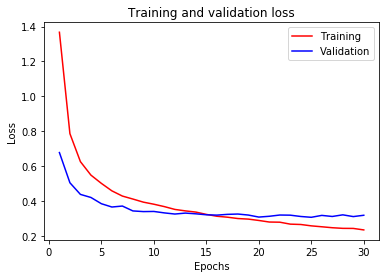

In [5]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'r', label='Training')
    plt.plot(epochs, val_loss, 'b', label='Validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

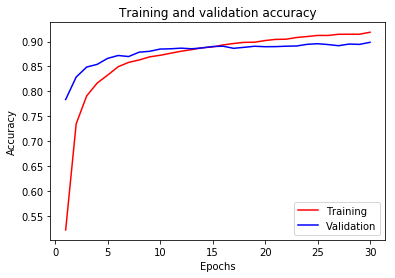

In [6]:
def plot_accuracy(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Training')
    plt.plot(epochs, val_acc, 'b', label='Validation')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plot_accuracy(history)

## Classifying newswires

---

Build a network to classify Reuters newswires into 46 different mutually-exclusive topics.

### Load and review the data

In [7]:
(reuters_train_data, reuters_train_labels), (reuters_test_data, reuters_test_labels) = reuters.load_data(num_words=10000)

print(reuters_train_data.shape)
print(len(reuters_train_data[0]))
print(len(reuters_train_data[1]))
maxs = 0
sizes = np.array([])
for d in reuters_train_data:
    sizes = np.append(sizes, len(d))
    if len(d) > maxs:
        maxs = len(d)
print(maxs)
print(np.mean(sizes))
print(reuters_train_labels.shape)
print(reuters_train_data[1])
print(reuters_train_labels[0])

print(set(reuters_train_labels))

(8982,)
87
56
2376
145.5398574927633
(8982,)
[1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]
3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


Load the word index to decode the train data.

In [8]:
word_index = reuters.get_word_index()

reverse_index = dict([(value+3, key) for (key, value) in word_index.items()])

reverse_index[0] = "<PAD>"
reverse_index[1] = "<START>"
reverse_index[2] = "<UNKNOWN>"  # unknown
reverse_index[3] = "<UNUSED>"

def decoded_review(i):
    return ' '.join([reverse_index.get(i,'?') for i in reuters_train_data[i]])

print(decoded_review(0))

<START> <UNKNOWN> <UNKNOWN> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [9]:
# Preprocess data
# Uniform sizes
tokenizer = Tokenizer(num_words=150)
tokenizer.fit_on_sequences(reuters_train_data)
reuters_train_data = tokenizer.sequences_to_matrix(reuters_train_data, mode='tfidf')
reuters_test_data = tokenizer.sequences_to_matrix(reuters_test_data, mode='tfidf')
# One hot encoding
reuters_train_encoded = to_categorical(reuters_train_labels)
reuters_test_encoded = to_categorical(reuters_test_labels)

In [10]:
# Building the model architecture
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_dim=150))
model.add(layers.Dropout(0.3))
#model.add(layers.Dense(2000, activation='relu'))
#model.add(layers.Dropout(0.3))
#model.add(layers.Dense(850, activation='relu'))
#model.add(layers.Dropout(0.3))
#model.add(layers.Dense(455, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

# included the early stopping which monitors the validation loss
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                4832      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 46)                1518      
Total params: 6,350
Trainable params: 6,350
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(reuters_train_data, reuters_train_encoded,
          #batch_size=5000,
          epochs=300,
          validation_split=0.2,
          callbacks=[early_stop], 
          verbose=2
                   )

Train on 7185 samples, validate on 1797 samples
Epoch 1/300
 - 1s - loss: 2.3150 - categorical_accuracy: 0.4693 - val_loss: 1.6777 - val_categorical_accuracy: 0.5904
Epoch 2/300
 - 0s - loss: 1.6635 - categorical_accuracy: 0.6018 - val_loss: 1.4473 - val_categorical_accuracy: 0.6633
Epoch 3/300
 - 0s - loss: 1.4805 - categorical_accuracy: 0.6514 - val_loss: 1.3281 - val_categorical_accuracy: 0.6923
Epoch 4/300
 - 0s - loss: 1.3666 - categorical_accuracy: 0.6728 - val_loss: 1.2673 - val_categorical_accuracy: 0.7073
Epoch 5/300
 - 0s - loss: 1.3051 - categorical_accuracy: 0.6834 - val_loss: 1.2232 - val_categorical_accuracy: 0.7162
Epoch 6/300
 - 0s - loss: 1.2630 - categorical_accuracy: 0.6903 - val_loss: 1.2021 - val_categorical_accuracy: 0.7162
Epoch 7/300
 - 0s - loss: 1.2166 - categorical_accuracy: 0.6998 - val_loss: 1.1747 - val_categorical_accuracy: 0.7212
Epoch 8/300
 - 0s - loss: 1.1685 - categorical_accuracy: 0.7100 - val_loss: 1.1550 - val_categorical_accuracy: 0.7229
Epoch 9/

In [12]:
results = model.evaluate(reuters_test_data, reuters_test_encoded)

print(results)

def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
    
limit_mem()

2246/2246 [==============================] - 0s 17us/step
[1.2119279330262942, 0.7190560997328584]


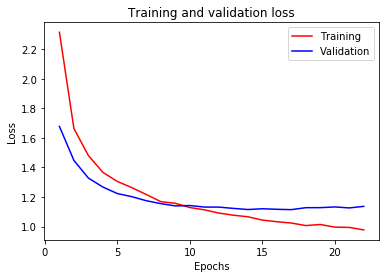

In [13]:
plot_loss(history)

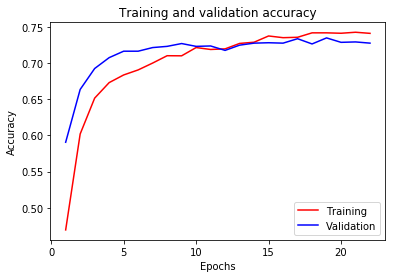

In [14]:
plot_accuracy(history)

## Predicting Student Admissions

---

Predict student admissions based on three pieces of data:

- GRE Scores
- GPA Scores
- Class rank

### Load and visualize the data

In [15]:
student_data = pd.read_csv("student_data.csv")
print(student_data)

     admit    gre   gpa  rank
0        0  380.0  3.61   3.0
1        1  660.0  3.67   3.0
2        1  800.0  4.00   1.0
3        1  640.0  3.19   4.0
4        0  520.0  2.93   4.0
5        1  760.0  3.00   2.0
6        1  560.0  2.98   1.0
7        0  400.0  3.08   2.0
8        1  540.0  3.39   3.0
9        0  700.0  3.92   2.0
10       0  800.0  4.00   4.0
11       0  440.0  3.22   1.0
12       1  760.0  4.00   1.0
13       0  700.0  3.08   2.0
14       1  700.0  4.00   1.0
15       0  480.0  3.44   3.0
16       0  780.0  3.87   4.0
17       0  360.0  2.56   3.0
18       0  800.0  3.75   2.0
19       1  540.0  3.81   1.0
20       0  500.0  3.17   3.0
21       1  660.0  3.63   2.0
22       0  600.0  2.82   4.0
23       0  680.0  3.19   4.0
24       1  760.0  3.35   2.0
25       1  800.0  3.66   1.0
26       1  620.0  3.61   1.0
27       1  520.0  3.74   4.0
28       1  780.0  3.22   2.0
29       0  520.0  3.29   1.0
..     ...    ...   ...   ...
370      1  540.0  3.77   2.0
371      1

Plot of the GRE and the GPA from the data.

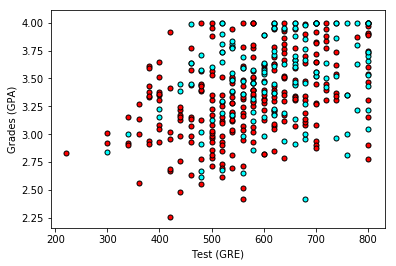

In [16]:
X = np.array(student_data[["gre","gpa"]])
y = np.array(student_data["admit"])
admitted = X[np.argwhere(y==1)]
rejected = X[np.argwhere(y==0)]
plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
plt.xlabel('Test (GRE)')
plt.ylabel('Grades (GPA)')

plt.show()

Plot of the data by class rank.

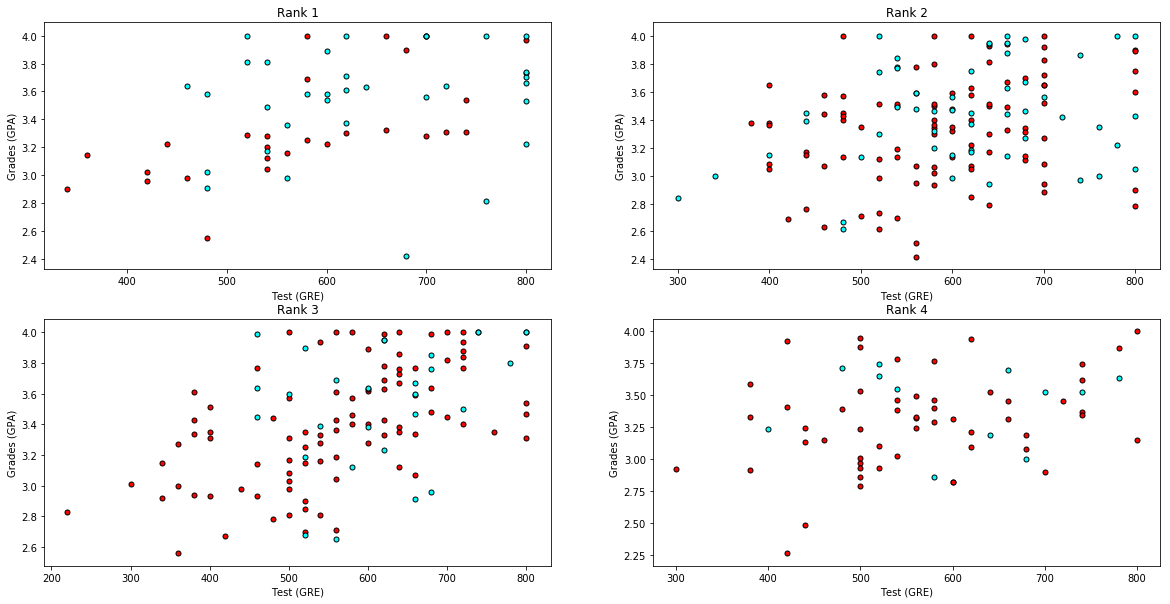

In [17]:
f, plots = plt.subplots(2, 2, figsize=(20,10))
plots = [plot for sublist in plots for plot in sublist]

for idx, plot in enumerate(plots):
    data_rank = student_data[student_data["rank"]==idx+1]
    plot.set_title("Rank " + str(idx+1))
    X = np.array(data_rank[["gre","gpa"]])
    y = np.array(data_rank["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plot.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plot.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plot.set_xlabel('Test (GRE)')
    plot.set_ylabel('Grades (GPA)')
    

#### TO DO: Preprocess the data

1. Normalize the input data set
2. Perform one hot encoding
3. Create a train, test, and validation set

#### TO DO: Define and train a network, then plot the accuracy of the training, validation, and testing

1. Use a validation set
2. Propose and train a network
3. Print the history of the training
4. Evaluate with a test set

In [18]:
# Data preprocess
corrected_data = []
for admit, gre, gpa, rank in zip(student_data["admit"],student_data["gre"],student_data["gpa"],student_data["rank"]):
    # Build new array filtering wrong data
    try:
        corrected_data.append(np.array([int(admit), float(gre), float(gpa), int(rank)]))
    except Exception as e:
        print(e)

data = np.array(corrected_data, dtype = np.float32)
# One hot encoding
labels = to_categorical(data[:, [0]])
#print(labels)
data = data[:, [1, 2, 3]]

#print(data)
print(len(labels))
# Divide dataset in the following sets (80% (60% training, 20% val), 20% test)
student_training_data = data[:320,:]
student_training_labels = labels[:320,:]

student_test_data = data[320:,:]
student_test_labels = labels[320:,:]
print(len(student_test_data))
#print(len(student_training_labels))
print(student_training_data.shape)
print(student_training_labels.shape)

cannot convert float NaN to integer
399
79
(320, 3)
(320, 2)


In [26]:
# Building the model architecture
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_dim=3))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation="softmax"))
model.summary()

#Learning rate is too high, reduce lr
optimizer = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# included the early stopping which monitors the validation loss
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 18        
Total para

In [27]:
history = model.fit(student_training_data, student_training_labels,
          #batch_size=5000,
          epochs=10,
          validation_split=0.05,
          callbacks=[early_stop], 
          verbose=2
                   )

Train on 304 samples, validate on 16 samples
Epoch 1/10
 - 0s - loss: 2.8678 - categorical_accuracy: 0.6283 - val_loss: 0.6931 - val_categorical_accuracy: 0.6250
Epoch 2/10
 - 0s - loss: 0.6930 - categorical_accuracy: 0.6908 - val_loss: 0.6930 - val_categorical_accuracy: 0.6250
Epoch 3/10
 - 0s - loss: 0.6929 - categorical_accuracy: 0.6908 - val_loss: 0.6930 - val_categorical_accuracy: 0.6250
Epoch 4/10
 - 0s - loss: 0.6928 - categorical_accuracy: 0.6908 - val_loss: 0.6929 - val_categorical_accuracy: 0.6250
Epoch 5/10
 - 0s - loss: 0.6927 - categorical_accuracy: 0.6908 - val_loss: 0.6928 - val_categorical_accuracy: 0.6250
Epoch 6/10
 - 0s - loss: 0.6926 - categorical_accuracy: 0.6908 - val_loss: 0.6928 - val_categorical_accuracy: 0.6250
Epoch 7/10
 - 0s - loss: 0.6925 - categorical_accuracy: 0.6908 - val_loss: 0.6927 - val_categorical_accuracy: 0.6250
Epoch 8/10
 - 0s - loss: 0.6924 - categorical_accuracy: 0.6908 - val_loss: 0.6926 - val_categorical_accuracy: 0.6250
Epoch 9/10
 - 0s - 

In [28]:
results = model.evaluate(student_test_data, student_test_labels)

print(results)

79/79 [==============================] - 0s 54us/step
[0.6922540068626404, 0.6708860804763022]


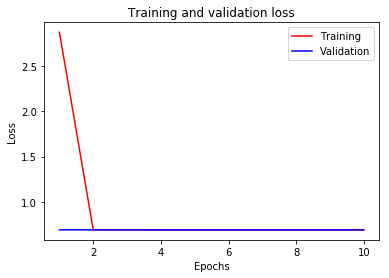

In [29]:
plot_loss(history)

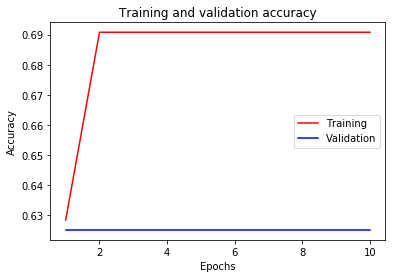

In [30]:
plot_accuracy(history)

# Conclusions

---
## General methodology

In all the previous cases I first created models with the highest accuracy, but these models didnt worked well with test data as they were overfitted. With the help of loss and accuracy plots I realized when to stop model training, the now less trained (less overfitted) models perform better in the general case balancing the results between train, test and validation data.

To reduce overfitt I added dropout to the layers and reduce the number of neurons and layers. Reducing the complexity of the model and adding auto stop helped achieve better general results.

## Dataset problems

According to results during model development we can conclude datasets 2 and 3 are too small to achieve 85% of accuracy. As we can see in the plots, the number of examples is not enough to increase accuracy while keeping training and validation uniform.
